In [35]:
import warnings
warnings.filterwarnings("ignore")

In [36]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
from scipy.spatial import distance as dist

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

import time

In [37]:
video_file = cv2.VideoCapture('../data/cam1_resized.mp4') 

In [38]:
def calculate_ear(eye):
    y1 = dist.euclidean(eye[2], eye[3])
    y2 = dist.euclidean(eye[4], eye[5])

    x1 = dist.euclidean(eye[0], eye[1])

    ear = (y1 + y2) / x1

    return ear

In [39]:
def landmark_detection(img, detector):
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)

    detection_result = detector.detect(mp_image)

    face_landmarks_list = detection_result.face_landmarks
    annotated_image = np.copy(mp_image.numpy_view())

    left_ear = 0
    right_ear = 0
    
    
    # print(len(face_landmarks_list))
    
    for idx in range(len(face_landmarks_list)):
    
        face_landmarks = face_landmarks_list[idx]

        left_eye = []
        right_eye = []
        for i in [33, 133, 159, 145, 158, 153]:
            left_eye.append((int(face_landmarks[i].x * annotated_image.shape[1]),
                             int(face_landmarks[i].y * annotated_image.shape[0])))

        for i in [263, 362, 385, 380, 386, 374]:
            right_eye.append((int(face_landmarks[i].x * annotated_image.shape[1]),
                             int(face_landmarks[i].y * annotated_image.shape[0])))

        for point in left_eye:
            cv2.circle(annotated_image,
                       (point[0], point[1]),
                       radius=2,
                       color=(0, 0, 255),
                       thickness=-1)

        for point in right_eye:
            cv2.circle(annotated_image,
                       (point[0], point[1]),
                       radius=2,
                       color=(0, 0, 255),
                       thickness=-1)

        left_ear = calculate_ear(left_eye)
        right_ear = calculate_ear(right_eye)

    return annotated_image, left_ear, right_ear

In [40]:
base_options = python.BaseOptions(model_asset_path='../models/face_landmarker.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)

detector = vision.FaceLandmarker.create_from_options(options)

color_green = (0, 255, 0)
line_width = 3

W0000 00:00:1697715766.135891   82500 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


In [41]:
ear_list = []

while True:
    read, frame = video_file.read()
    
    if not read:
        break
    
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    img, left_ear, right_ear = landmark_detection(rgb_frame, detector)
    
#     plt.imshow(img)
#     plt.show()
    
#     time.sleep(1)
    
    ear_list.append((left_ear + right_ear) / 2)

ear_list = np.array(ear_list)

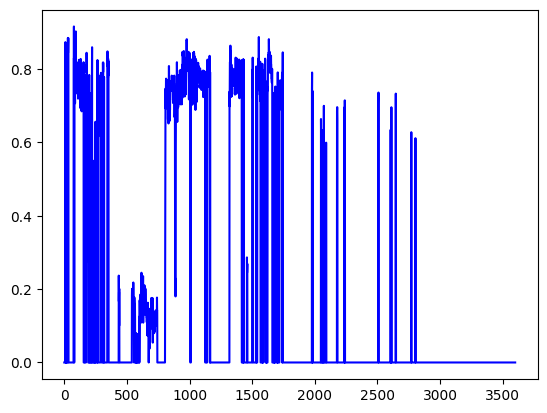

In [42]:
plt.plot(ear_list, color='b')